## P2

In [1]:
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
DATA_PATH="../../data/pml/"

# Load Data

In [3]:
X, y = shuffle(np.load(DATA_PATH+'x_train.npy'), np.load(DATA_PATH+'y_train.npy'))
data_test = np.load(DATA_PATH+'x_test.npy')

In [4]:
columns=X.dtype.names

In [5]:
df_train=pd.DataFrame(X, columns=columns)
df_test=pd.DataFrame(data_test, columns=columns)

In [6]:
df_test.sample(5)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
1005,2014-05-29,2.0,1.00,950,7560,1.0,False,3,6,950,0,1958,0,98058,47.449902,-122.176003
1323,2014-09-11,3.0,3.00,2490,3600,2.0,False,4,8,1790,700,1911,0,98119,47.631302,-122.369003
5801,2015-04-17,2.0,1.00,1210,10000,1.0,False,3,7,1210,0,1953,0,98148,47.440201,-122.333000
5041,2014-05-08,3.0,1.75,950,6000,1.0,False,3,6,790,160,1939,0,98108,47.527100,-122.316002
1287,2015-02-13,3.0,1.75,1320,7725,1.0,False,3,8,1320,0,1978,0,98058,47.442501,-122.133003


## Decrease skewness of Price

In [7]:
df_train['Price']=y

In [8]:
df_train.Price.describe()

count    1.500000e+04
mean     5.405347e+05
std      3.670720e+05
min      7.500000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: Price, dtype: float64

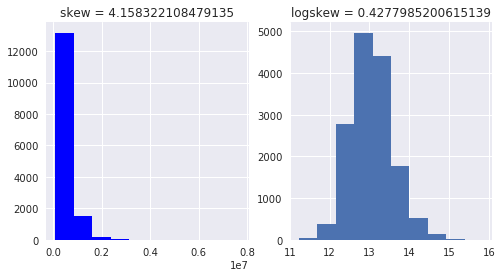

In [9]:
width, height = 2, 1
plt.figure(figsize=(8, 4))

plt.subplot(height, width, 1)
plt.hist(y, color='blue')
name='skew = %s'%df_train.Price.skew()
plt.title(name)

df_train['target'] = np.log1p(df_train.Price)
plt.subplot(height, width, 2)
name='logskew = %s'%df_train.target.skew()
plt.hist(df_train.target)
plt.title(name)

plt.show()
# A value closer to 0 means that we have improved the skewness of the data.

# drop outliers
df_train.drop(df_train[(df_train['sqft_living'] > 9000)].index,inplace=True)
plt.figure()
otl = sns.lmplot('sqft_living', 'Price',data=df_train, fit_reg=False)
plt.xlim(0,9500)
plt.ylim(0,6000000)

## Encode zipcode

len(np.unique(df_train.zipcode)),len(np.unique(df_test.zipcode))

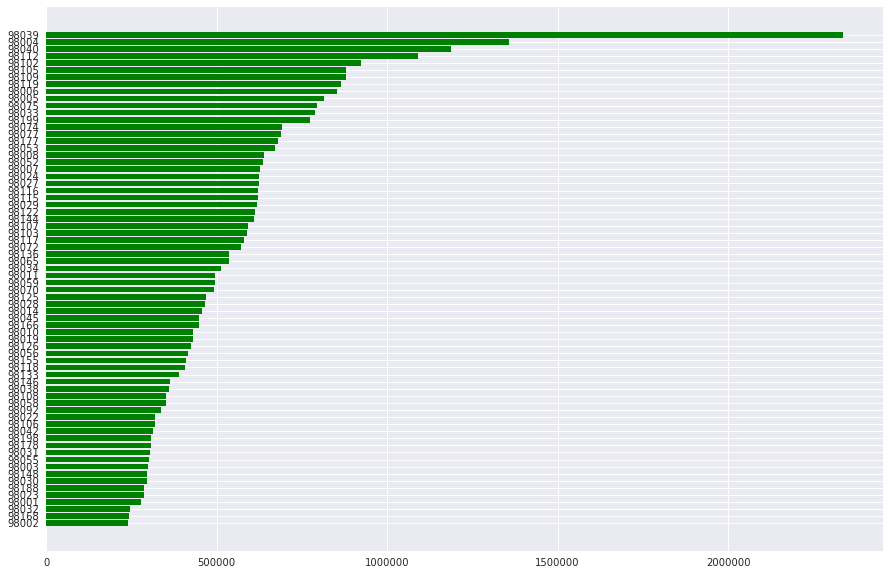

In [10]:
def calculate_zip_plot(df):
    y_plot=df.groupby('zipcode')['Price'].mean()
    y_plot=y_plot.sort_values()
    zip_labels=y_plot.index.astype('str')
    y_pos=np.arange(len(zip_labels))
    x=y_plot.values
    plt.figure(figsize=(15,10))

    plt.barh(y_pos, x, color='green')
    plt.yticks(y_pos,zip_labels)
    
    y_plot=y_plot.reset_index()
    
    plt.show()
    
    return y_plot

y_plot=calculate_zip_plot(df_train)

In [11]:
# Divide into 5 categories
def get_zipcodes(y_plot):
    n=len(y_plot.index)
    y_pos=y_plot.zipcode
    d1=n//5
    
    dic={}
    for ix in range(d1):
        r=y_pos[ix]
        dic[r]=5
    for ix in range(d1,2*d1):
        r=y_pos[ix]
        dic[r]=4
    for ix in range(2*d1,3*d1):
        r=y_pos[ix]        
        dic[r]=3
    for ix in range(3*d1,4*d1):
        r=y_pos[ix]        
        dic[r]=2
    for ix in range(4*d1,n):
        r=y_pos[ix]        
        dic[r]=1
    return dic

dic=get_zipcodes(y_plot)

In [12]:
# In order to avoid repeating unnecessary codes, for our convenience, let's combine the train and test set.
df = pd.concat([df_train.drop(['Price','target'],axis=1), df_test]).reset_index()

df.drop(['index'],axis=1,inplace=True)

# Analysis of Features

## Feature analysis (skipped)

## categorical data

# Preprocessing

In [13]:
from sklearn import preprocessing

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:

$x_{sin} = \sin(\frac{2 * \pi * x}{\max(x)})$

$x_{cos} = \cos(\frac{2 * \pi * x}{\max(x)})$

Let's do this for our hourly data:

In [14]:
def simplify_date(df):
    df['year_date'] = pd.DatetimeIndex(df['date']).year
    df['month_date'] = pd.DatetimeIndex(df['date']).month
    df['day_date']= pd.DatetimeIndex(df['date']).day
    return df.drop("date",axis=1)

def simplify_month_day(df):
    df['mnth_sin'] = np.sin((df.month_date-1)*(2.*np.pi/12))
    df['mnth_cos'] = np.cos((df.month_date-1)*(2.*np.pi/12))
    return df

def simplify_xy(df):
    df['R']=np.sqrt(np.power(df.long,2)+np.power(df.lat,2))
    return df.drop(['long','lat'],axis=1)

def calculate_age(df):
    #age
    df.yr_built = df.year_date - df.yr_built
    #asnew
    df.yr_renovated = df.year_date - df.yr_renovated
    df.yr_renovated[(df.yr_renovated<0)]=df.year_date[(df.yr_renovated<0)]
    df.drop('year_date',axis=1,inplace=True)
    return df

def transform_zipcode(df,dic):
    df.zipcode=df.zipcode.map(dic)
    return df

def transform(df):
    df=simplify_date(df)
    df=simplify_month_day(df)
    df=df.drop(["month_date","day_date"],axis=1)
    df=simplify_xy(df)
    df=calculate_age(df)
    df=transform_zipcode(df,dic)
    return df

In [15]:
df=transform(df)
df.sample(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,mnth_sin,mnth_cos,R
8761,2.0,2.25,1560,1705,2.0,False,3,8,1270,290,8,2014,4,-5.000000e-01,8.660254e-01,131.286819
14764,3.0,2.00,2120,7560,1.0,False,3,9,2120,0,23,2014,4,8.660254e-01,-5.000000e-01,131.046356
17335,2.0,1.50,1750,46173,2.0,False,4,8,1750,0,50,2014,3,-5.000000e-01,-8.660254e-01,131.125290
18255,3.0,1.00,1380,30940,2.0,False,3,8,1380,0,38,2014,5,1.224647e-16,-1.000000e+00,130.959473
17815,2.0,1.75,1700,18000,1.0,False,3,8,1700,0,42,2014,4,-5.000000e-01,8.660254e-01,131.103973
16586,4.0,3.75,3180,9889,2.0,False,3,9,2500,680,2,2014,1,-8.660254e-01,5.000000e-01,131.178146
7679,3.0,1.00,1270,7500,1.0,False,3,7,1270,0,62,2015,4,1.000000e+00,6.123234e-17,131.233871
8713,4.0,2.25,3010,9800,2.0,False,4,9,3010,0,41,2014,1,-8.660254e-01,5.000000e-01,131.140778
6316,3.0,2.00,2010,4000,1.0,False,5,7,1210,800,99,2014,3,-5.000000e-01,-8.660254e-01,131.286789
5895,4.0,2.50,2520,10850,1.0,False,4,8,1680,840,46,2014,4,-5.000000e-01,8.660254e-01,131.285324


In [16]:
from sklearn.preprocessing import LabelEncoder

ordinals = ['condition','grade','waterfront','zipcode']

for ordinal in ordinals:
    le = LabelEncoder()
    le.fit(df[ordinal])
    df[ordinal] = le.transform(df[ordinal])
df.sample(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,mnth_sin,mnth_cos,R
14950,4.0,3.25,3640,13530,1.0,0,2,7,2570,1070,91,15,0,1.000000e+00,6.123234e-17,131.189468
17556,3.0,2.00,1600,16530,1.0,0,4,5,1600,0,47,2014,0,-8.660254e-01,-5.000000e-01,130.965500
18076,5.0,3.00,3880,8432,2.0,0,2,5,3880,0,10,2014,3,-8.660254e-01,-5.000000e-01,131.077774
12171,4.0,2.00,1760,5307,1.5,0,3,5,1170,590,66,2014,0,-1.000000e+00,-1.836970e-16,131.243896
19570,5.0,2.50,3270,6129,2.0,0,2,7,3270,0,10,2014,4,-5.000000e-01,8.660254e-01,131.095108
20035,3.0,1.75,2660,7800,1.0,0,3,6,1330,1330,64,2015,2,5.000000e-01,8.660254e-01,131.345337
2197,2.0,1.00,960,223898,1.0,0,2,4,960,0,29,2014,2,-5.000000e-01,-8.660254e-01,130.880798
5250,3.0,3.25,1560,1345,2.0,0,2,6,1260,300,6,2015,3,1.000000e+00,6.123234e-17,131.293350
283,4.0,2.00,2670,3240,1.5,0,3,7,1780,890,84,2014,1,1.224647e-16,-1.000000e+00,131.225266
19303,4.0,2.25,2040,12000,1.0,0,3,5,1300,740,52,2015,2,1.000000e+00,6.123234e-17,131.231110


In [17]:
# Assign numeric features by excluding non numeric features
numeric = df.dtypes[df.dtypes != 'object'].index

# Display the skewness of each column and sort the values in descending order 
skewness = df[numeric].apply(lambda x: x.skew()).sort_values(ascending=False)

# Create a dataframe and show 5 most skewed features 
sk_df = pd.DataFrame(skewness,columns=['skewness'])
sk_df['skw'] = abs(sk_df)
sk_df.sort_values('skw',ascending=False).drop('skw',axis=1)

,skewness
sqft_lot,13.060019
waterfront,11.385108
yr_renovated,-4.566595
bedrooms,1.974300
sqft_basement,1.577965
sqft_living,1.471555
sqft_above,1.446664
condition,1.032805
grade,0.774712
R,-0.706282


In [18]:
skw_feature = skewness[abs(skewness) > 0.5].index

# Transform skewed features to normal distribution by taking log(1 + input)
df[skw_feature] = np.log1p(df[skw_feature])

In [19]:
df.sample(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,mnth_sin,mnth_cos,R
7395,1.609438,1.446919,7.958926,8.210940,1.098612,0.000000,1.098612,2.079442,7.591357,6.781058,90,3.135494,1,8.660254e-01,5.000000e-01,4.884799
1197,1.609438,1.252763,7.841100,8.719481,1.098612,0.000000,1.098612,1.945910,7.841100,0.000000,0,7.608374,4,-1.000000e+00,-1.836970e-16,4.883187
12081,1.609438,1.386294,8.006701,9.239705,1.098612,0.000000,1.098612,1.945910,8.006701,0.000000,11,7.608374,4,-5.000000e-01,-8.660254e-01,4.882356
4942,0.693147,0.559616,6.660575,11.259374,0.693147,0.000000,0.000000,1.386294,6.660575,0.000000,70,7.608871,3,0.000000e+00,1.000000e+00,4.882770
6676,1.386294,0.916291,7.596392,8.696009,0.916291,0.693147,1.386294,1.791759,7.596392,0.000000,88,7.608374,4,1.224647e-16,-1.000000e+00,4.884099
5464,1.609438,1.098612,7.630947,8.764210,0.693147,0.000000,1.098612,1.791759,7.065613,6.792344,38,7.608871,4,5.000000e-01,8.660254e-01,4.883024
15327,1.386294,0.693147,7.139660,8.699681,0.693147,0.000000,1.386294,1.609438,7.139660,0.000000,61,7.608871,4,8.660254e-01,-5.000000e-01,4.884259
14838,1.386294,1.178655,7.581210,9.224243,1.098612,0.000000,1.098612,1.945910,7.581210,0.000000,31,7.608871,0,1.000000e+00,6.123234e-17,4.883040
20522,1.098612,1.252763,7.215975,7.898782,1.098612,0.000000,1.098612,1.609438,7.215975,0.000000,11,7.608374,3,-5.000000e-01,-8.660254e-01,4.881964
15626,1.609438,1.178655,7.669028,9.090994,1.098612,0.000000,1.098612,1.945910,7.669028,0.000000,29,7.608871,3,0.000000e+00,1.000000e+00,4.883091


In [20]:
np.all(np.isfinite(df))#3271

bedrooms         True
bathrooms        True
sqft_living      True
sqft_lot         True
floors           True
waterfront       True
condition        True
grade            True
sqft_above       True
sqft_basement    True
yr_built         True
yr_renovated     True
zipcode          True
mnth_sin         True
mnth_cos         True
R                True
dtype: bool

In [21]:
X_train = df[:df_train.shape[0]]
X_test = df[df_train.shape[0]:]
print("training shape:{}, test shape:{}".format(X_train.shape,X_test.shape))

training shape:(15000, 16), test shape:(6613, 16)


In [22]:
X_train.sample(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,mnth_sin,mnth_cos,R
9513,1.609438,1.558145,8.394121,9.158310,1.098612,0.0,1.098612,2.079442,8.137688,6.908755,52,2.302585,2,-1.000000,-1.836970e-16,4.884806
4689,1.386294,1.252763,7.601402,8.882669,1.098612,0.0,1.098612,1.945910,7.601402,0.000000,17,7.608871,4,0.866025,5.000000e-01,4.883922
7218,1.386294,1.252763,7.462215,8.222016,1.098612,0.0,1.098612,1.945910,7.462215,0.000000,5,7.608374,4,-1.000000,-1.836970e-16,4.883257
10949,1.386294,1.252763,8.033009,8.630343,1.098612,0.0,1.098612,1.945910,8.033009,0.000000,9,7.608871,4,0.500000,8.660254e-01,4.883484
9652,1.386294,1.098612,7.425954,9.536979,0.693147,0.0,1.098612,1.791759,7.425954,0.000000,21,7.608871,4,0.866025,-5.000000e-01,4.883199
13298,1.609438,1.252763,7.852050,10.008568,1.098612,0.0,1.609438,1.791759,7.852050,0.000000,56,7.608374,2,-0.866025,-5.000000e-01,4.883264
8245,1.386294,1.252763,7.800163,8.331827,1.098612,0.0,1.098612,2.079442,7.800163,0.000000,11,7.608374,1,0.500000,-8.660254e-01,4.883270
10771,1.609438,0.916291,7.444833,8.434029,0.916291,0.0,1.098612,1.791759,7.444833,0.000000,90,7.608374,1,-0.500000,8.660254e-01,4.884952
441,1.609438,1.011601,7.705713,8.779711,1.098612,0.0,1.386294,1.945910,7.705713,0.000000,50,7.608374,2,0.500000,-8.660254e-01,4.884716
684,1.609438,1.446919,8.258681,9.788133,0.693147,0.0,1.386294,2.197225,7.875119,7.115582,39,7.608374,0,-0.500000,-8.660254e-01,4.884055


def grade_plot(df):
    y_plot=df.groupby('condition')['Price'].mean()
    y_plot=y_plot.sort_values()
    zip_labels=y_plot.index.astype('str')
    y_pos=np.arange(len(zip_labels))
    x=y_plot.values
    plt.figure(figsize=(15,10))

    plt.barh(y_pos, x, color='green')
    plt.yticks(y_pos,zip_labels)
    
    plt.show()
grade_plot(df_train)

In [23]:
null_columns=X_train.columns[X_train.isnull().any()]
X_train[null_columns].isnull().sum()

Series([], dtype: float64)

In [24]:
df.dtypes

bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
condition        float64
grade            float64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
mnth_sin         float64
mnth_cos         float64
R                float64
dtype: object

In [25]:
np.any(np.isnan(X_train))

bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
mnth_sin         False
mnth_cos         False
R                False
dtype: bool

In [26]:
np.all(np.isfinite(X_train))

bedrooms         True
bathrooms        True
sqft_living      True
sqft_lot         True
floors           True
waterfront       True
condition        True
grade            True
sqft_above       True
sqft_basement    True
yr_built         True
yr_renovated     True
zipcode          True
mnth_sin         True
mnth_cos         True
R                True
dtype: bool

In [27]:
X_train[(X_train.yr_renovated==np.inf)]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,mnth_sin,mnth_cos,R


In [28]:
np.any(np.isnan(df_train.target))

False

## PCA

In [29]:
from sklearn.decomposition import PCA

In [30]:
len(df_train.columns)

18

In [39]:
pca_range=range(1,len(X_train.columns))
scores =[]
for i in pca_range:
    clf=RandomForestRegressor()
    pca_hp = PCA(i)
    x_fit = pca_hp.fit_transform(X_train)
    scores.append(cross_val_score(clf, x_fit, df_train.target, cv=5, scoring=mape_scorer).mean())

([<matplotlib.axis.YTick at 0x7fa7048861d0>,
 <a list of 15 Text yticklabel objects>)

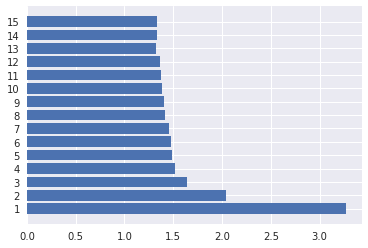

In [40]:
plt.barh(pca_range,scores)
plt.yticks(pca_range,pca_range)

# Declare Loss MAPE function

In [32]:
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer=make_scorer(mean_absolute_percentage_error)

# Find best model

In [33]:
best_model=None
best_loss=2.0

In [34]:
from sklearn.linear_model import SGDRegressor, Lasso, LinearRegression, Ridge, ElasticNet, HuberRegressor, ElasticNetCV,BayesianRidge
from sklearn.ensemble import RandomForestRegressor # do not use
from xgboost import XGBRegressor # do not use

models=[
    RandomForestRegressor(),
        HuberRegressor(),
        ElasticNet(),
        LinearRegression(),
        Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        Lasso(),
        SGDRegressor(),
        Ridge(alpha=1.0),
    BayesianRidge(),
       ]

In [41]:
def cv_score(model,x_train,y_train):
    global best_model,best_loss
    clf =model
#     pca=PCA(15)
#     pca_df=pca.fit_transform(df)
#     train_pca = df[:df_train.shape[0]]
#     test_pca = df[df_train.shape[0]:]
    score=cross_val_score(clf, x_train, y_train, cv=5, scoring=mape_scorer).mean()
    if score < best_loss:
        best_model = clf
        best_loss = score
    return score

In [42]:
for model in models:
    cv_score(model,X_train,df_train.target)
print(f'best: {best_loss}\t{best_model}\n')

best: 1.1287805452882727	RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)



# Predict & Submit

In [44]:
kfold = KFold(n_splits=20, random_state= 0, shuffle = True)

In [ ]:
clf=RandomForestRegressor()
# 1.353714876410685 outliers dropped
# 1.1636898483624054 with outliers

In [46]:
cross_val_score(gsXGB, X_train, df_train.target, cv=5, scoring=mape_scorer).mean()

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    4.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.8s finished


1.06248193422518

In [ ]:
clf.fit(train_pca,df_train.target)
preds=np.expm1(clf.predict(test_pca))

In [ ]:
sum(n < 0 for n in preds)

In [49]:
XGB = XGBRegressor()

xg_param_grid = {
              'n_estimators' :[870],
              'learning_rate': [0.04],
              
              'max_depth': [3],
              'min_child_weight':[0.2],
              
              'gamma': [0],
                
              'subsample':[0.8],
              'colsample_bytree':[0.7]
    
              #'reg_alpha':[0.08,0.09,0.095,0.1,0.15,0.2],
              #'reg_lambda':[0,0.001,0.002]
              }
                
gsXGB = GridSearchCV(XGB,param_grid = xg_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)

gsXGB.fit(
    X_train,
    df_train.target
)
XGB_best = gsXGB.best_estimator_
print(gsXGB.best_params_)

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    5.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.3s finished


{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 0.2, 'n_estimators': 870, 'subsample': 0.8}


In [ ]:
elnet = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.003, 0.007, 0.009, 0.01, 0.03, 0.05, 0.07, 0.09, 0.2, 0.4, 0.6, 0.8, 1, 1.2] 
                ,l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
                ,cv = kfold, random_state = 1, n_jobs = -1)
elnet.fit(X_train, df_train.target)
alpha = elnet.alpha_
ratio = elnet.l1_ratio_
print("Optimized Alpha:", alpha)
print("Optimized l1_ratio:", ratio)

elnet = ElasticNetCV(alphas = alpha * np.linspace(0.5,1.5,20), l1_ratio = ratio * np.linspace(0.9,1.3,6), 
                     cv = kfold, random_state = 1, n_jobs = -1)
elnet.fit(X_train, df_train.target)

alpha = elnet.alpha_
ratio = elnet.l1_ratio_

print("Final Alpha:", alpha)
print("Final l1_ratio:", ratio)

In [50]:
preds = np.expm1(gsXGB.predict(X_test))

In [ ]:
preds[preds < 0]=preds.mean()

In [ ]:
import datetime
with open(f'prediction{datetime.datetime.now()}.csv', 'w') as out:
    print('Id,Price', file=out)
    for pair in enumerate(preds, 1):
        print('%i,%d' % pair, file=out)

In [ ]:
preds[:10]

!["Logo Title Text 1"](https://cdn-images-1.medium.com/max/1000/0*KH3dnbGNcmyV_ODL.png "Logo Title Text 1")